In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [52]:
df=pd.read_csv('D:\\Downloads\\kaggletitanic\\train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#preprocessing
#Name is not needed- we can extract Mr, master, Mrs, Ms from the string
#Mr, master --> Male
#Mrs, Ms --> Female
#every other title can be confined to mr,master,ms,mrs
#sibsp and parch can be combined to family size -->famsize=sibsp+parch
#Age and Pclass both are directly proportional to Survived --> age*class
#fare_per_person = fare/(fam_size+1)  1- individual
#cabin can be reframed to deck
#fill empty values - data imputation - mean
#model - Random Forest

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import string
import seaborn as sns

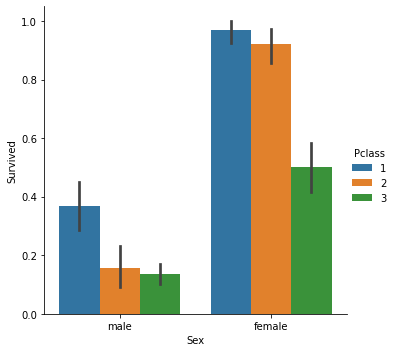

In [12]:
sns.catplot(data=df, x="Sex", y="Survived", hue="Pclass", kind="bar")

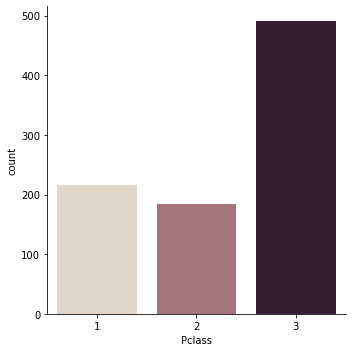

In [13]:
sns.catplot(data=df, x="Pclass", kind="count", palette="ch:.25")
#more no.of people travelled in 3rd class

In [29]:
#age vs survival
sur=df.groupby('Survived')
print(sur.count()['PassengerId'])

Survived
0    549
1    342
Name: PassengerId, dtype: int64


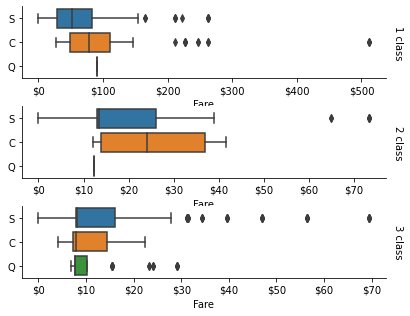

In [21]:
g = sns.catplot(
    data=df,
    x="Fare", y="Embarked", row="Pclass",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Fare", ylabel="")
g.set_titles(row_template="{row_name} class")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('${x:.0f}')

In [38]:
#Mr,master,Mrs,Ms
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan

In [32]:
def phase1clean(df):
    #setting silly values to nan
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    
    #Special case for cabins as nan may be signal
    df.Cabin = df.Cabin.fillna('Unknown')    

    #creating a title column from name
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']

    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    
    #replacing all titles with mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title
    df['Title']=df.apply(replace_titles, axis=1)

    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
        
    #Creating new family_size column
    df['Family_Size']=df['SibSp']+df['Parch']
    
    return df

In [50]:
def phase2clean(train, test):
    #data type dictionary
    data_type_dict={'Pclass':'ordinal', 'Sex':'nominal', 
                    'Age':'numeric', 
                    'Fare':'numeric', 'Embarked':'nominal', 'Title':'nominal',
                    'Deck':'nominal', 'Family_Size':'ordinal'}      

    #imputing nan values
    for df in [train, test]:
        #classmeans = df.pivot_table('Fare', rows='Pclass', aggfunc='mean')
        #df.Fare = df[['Fare', 'Pclass']].apply(lambda x: classmeans[x['Pclass']] if pd.isnull(x['Fare']) else x['Fare'], axis=1 )
        meanAge=np.mean(df.Age)
        df.Age=df.Age.fillna(meanAge)
        modeEmbarked = mode(df.Embarked)[0][0]
        df.Embarked = df.Embarked.fillna(modeEmbarked)


#    Fare per person
    for df in [train, test]:
        df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)
    
    #Age times class
    for df in [train, test]:
        df['Age*Class']=df['Age']*df['Pclass']
    
    data_type_dict['Fare_Per_Person']='numeric'
    data_type_dict['Age*Class']='numeric'
    
    return [train,test, data_type_dict]


In [34]:
def discretise_numeric(train, test, data_type_dict, no_bins=10):
    N=len(train)
    M=len(test)
    test=test.rename(lambda x: x+N)
    joint_df=train.append(test)
    for column in data_type_dict:
        if data_type_dict[column]=='numeric':
            joint_df[column]=pd.qcut(joint_df[column], 10)
            data_type_dict[column]='ordinal'
    train=joint_df.ix[range(N)]
    test=joint_df.ix[range(N,N+M)]
    return train, test, data_type_dict


In [70]:
def create_pred():
    '''trainpath = 'D:\\Downloads\\kaggletitanic\\train.csv'
    testpath = 'D:\\Downloads\\kaggletitanic\\test.csv'
    traindf = pd.read_csv(trainpath)
    testdf = pd.read_csv(testpath)

    traindf=phase1clean(traindf)
    testdf=phase1clean(testdf)
    
    traindf, testdf, data_type_dict=phase2clean(traindf, testdf)
    
    traindf, testdf, data_type_dict=discretise_numeric(traindf, testdf, data_type_dict)'''
    
    #create a submission file for kaggle
    predictiondf = pd.DataFrame(testdf['PassengerId'])
    predictiondf['Survived']=[0 for x in range(len(testdf))]
    predictiondf.to_csv('D:\\Documents\\Predictiontitanic.csv',index=False)
    return [predictiondf]

In [59]:
df_new=phase1clean(df)
df_new

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,Unknown,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,Unknown,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Unknown,S,Mr,Unknown,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,B,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,Unknown,S,Miss,Unknown,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,C,0


In [53]:
df_test=pd.read_csv('D:\\Downloads\\kaggletitanic\\test.csv')

In [41]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [60]:
df_test_new=phase1clean(df_test)
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,Unknown,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,Unknown,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr,Unknown,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr,Unknown,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs,Unknown,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,Unknown,S,Mr,Unknown,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Mr,C,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,S,Mr,Unknown,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,Unknown,S,Mr,Unknown,0


In [62]:
traindf, testdf, data_type_dict=phase2clean(df_new, df_test_new)    

In [64]:
traindf.head()
testdf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size,Fare_Per_Person,Age*Class
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,Unknown,0,7.829200,103.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,Unknown,1,3.500000,141.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr,Unknown,0,9.687500,124.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr,Unknown,0,8.662500,81.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs,Unknown,2,4.095833,66.0


In [71]:
pred_df=create_pred()
pred_df

[     PassengerId  Survived
 0            892         0
 1            893         0
 2            894         0
 3            895         0
 4            896         0
 ..           ...       ...
 413         1305         0
 414         1306         0
 415         1307         0
 416         1308         0
 417         1309         0
 
 [418 rows x 2 columns]]

In [73]:
from sklearn.ensemble import RandomForestClassifier

y = traindf["Survived"]

features = ["Pclass", "Sex", "Age*Class","Family_Size"]
X = pd.get_dummies(traindf[features])
X_test = pd.get_dummies(testdf[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': testdf.PassengerId, 'Survived': predictions})
output.to_csv('D:\\Documents\\Predictiontitanic.csv', index=False)